# Method 9 - Best Ideas High Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[best_ideas['size_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

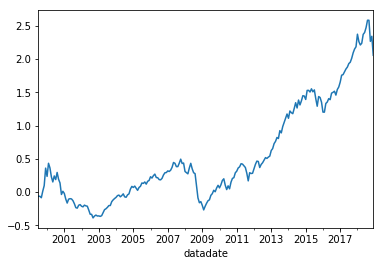

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.359351
2000-12-31   -0.256087
2001-12-31   -0.198791
2002-12-31   -0.211310
2003-12-31    0.412108
2004-12-31    0.202080
2005-12-31    0.082376
2006-12-31    0.101387
2007-12-31    0.110530
2008-12-31   -0.404092
2009-12-31    0.286740
2010-12-31    0.170640
2011-12-31   -0.005568
2012-12-31    0.201815
2013-12-31    0.411014
2014-12-31    0.124490
2015-12-31   -0.038017
2016-12-31    0.097152
2017-12-31    0.234606
2018-12-31   -0.040091
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     367.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.99e-98
Time:                        20:29:58   Log-Likelihood:                 607.56
No. Observations:                 234   AIC:                            -1205.
Df Residuals:                     229   BIC:                            -1188.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.727      0.468      -0.002       0.003
mktrf          0.9925      0.034     29.186      0.000       0.925       1.059
me             0.2913      0.040      7.365      0.000       0.213       0.369
ia            -0.3622      0.060     -6.025      0.000      -0.481      -0.244
roe            0.1972      0.051      3.832      0.000       0.096       0.299
==============================================================================
Omnibus:                      118.365   Durbin-Watson:                   2.306
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3037.216
Skew:                           1.379   Prob(JB):                         0.00
Kurtosis:                      20.433   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     202.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.57e-74
Time:                        20:29:58   Log-Likelihood:                 607.56
No. Observations:                 234   AIC:                            -1205.
Df Residuals:                     229   BIC:                            -1188.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.730      0.465      -0.002       0.003
mktrf          0.9925      0.041     24.274      0.000       0.912       1.073
me             0.2913      0.087      3.330      0.001       0.120       0.463
ia            -0.3622      0.162     -2.235      0.025      -0.680      -0.045
roe            0.1972      0.070      2.819      0.005       0.060       0.334
==============================================================================
Omnibus:                      118.365   Durbin-Watson:                   2.306
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3037.216
Skew:                           1.379   Prob(JB):                         0.00
Kurtosis:                      20.433   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     310.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.35e-91
Time:                        20:29:58   Log-Likelihood:                 607.56
No. Observations:                 234   AIC:                            -1205.
Df Residuals:                     229   BIC:                            -1188.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.719      0.472      -0.002       0.003
mktrf          0.9925      0.034     29.142      0.000       0.926       1.059
me             0.2913      0.089      3.274      0.001       0.117       0.466
ia            -0.3622      0.155     -2.341      0.019      -0.665      -0.059
roe            0.1972      0.067      2.945      0.003       0.066       0.328
==============================================================================
Omnibus:                      118.365   Durbin-Watson:                   2.306
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3037.216
Skew:                           1.379   Prob(JB):                         0.00
Kurtosis:                      20.433   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     271.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.42e-94
Time:                        20:29:58   Log-Likelihood:                 599.83
No. Observations:                 234   AIC:                            -1188.
Df Residuals:                     228   BIC:                            -1167.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.469      0.143      -0.001       0.004
mktrf          0.9448      0.035     26.770      0.000       0.875       1.014
smb            0.2342      0.047      5.029      0.000       0.142       0.326
hml           -0.2129      0.055     -3.877      0.000      -0.321      -0.105
rmw           -0.0353      0.062     -0.569      0.570      -0.158       0.087
cma           -0.0174      0.079     -0.221      0.826      -0.173       0.138
==============================================================================
Omnibus:                       92.431   Durbin-Watson:                   2.443
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2123.064
Skew:                           0.940   Prob(JB):                         0.00
Kurtosis:                      17.636   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     325.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.15e-101
Time:                        20:29:58   Log-Likelihood:                 599.83
No. Observations:                 234   AIC:                            -1188.
Df Residuals:                     228   BIC:                            -1167.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.473      0.141      -0.001       0.004
mktrf          0.9448      0.038     25.182      0.000       0.871       1.018
smb            0.2342      0.076      3.086      0.002       0.085       0.383
hml           -0.2129      0.074     -2.862      0.004      -0.359      -0.067
rmw           -0.0353      0.087     -0.404      0.686      -0.207       0.136
cma           -0.0174      0.173     -0.100      0.920      -0.357       0.323
==============================================================================
Omnibus:                       92.431   Durbin-Watson:                   2.443
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2123.064
Skew:                           0.940   Prob(JB):                         0.00
Kurtosis:                      17.636   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     523.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.12e-123
Time:                        20:29:58   Log-Likelihood:                 599.83
No. Observations:                 234   AIC:                            -1188.
Df Residuals:                     228   BIC:                            -1167.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.504      0.132      -0.001       0.004
mktrf          0.9448      0.035     27.344      0.000       0.877       1.013
smb            0.2342      0.067      3.481      0.001       0.102       0.366
hml           -0.2129      0.078     -2.735      0.006      -0.365      -0.060
rmw           -0.0353      0.091     -0.386      0.700      -0.215       0.144
cma           -0.0174      0.179     -0.097      0.922      -0.368       0.333
==============================================================================
Omnibus:                       92.431   Durbin-Watson:                   2.443
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2123.064
Skew:                           0.940   Prob(JB):                         0.00
Kurtosis:                      17.636   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     571.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.74e-118
Time:                        20:29:58   Log-Likelihood:                 653.27
No. Observations:                 234   AIC:                            -1297.
Df Residuals:                     229   BIC:                            -1279.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.181      0.857      -0.002       0.002
mktrf          1.0801      0.026     41.943      0.000       1.029       1.131
smb            0.1522      0.032      4.733      0.000       0.089       0.215
hml           -0.1277      0.032     -3.998      0.000      -0.191      -0.065
umd            0.2414      0.021     11.524      0.000       0.200       0.283
==============================================================================
Omnibus:                       88.188   Durbin-Watson:                   2.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1317.101
Skew:                           1.015   Prob(JB):                    9.89e-287
Kurtosis:                      14.444   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     374.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.08e-99
Time:                        20:29:58   Log-Likelihood:                 653.27
No. Observations:                 234   AIC:                            -1297.
Df Residuals:                     229   BIC:                            -1279.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.197      0.844      -0.002       0.002
mktrf          1.0801      0.047     22.963      0.000       0.988       1.172
smb            0.1522      0.048      3.167      0.002       0.058       0.246
hml           -0.1277      0.043     -2.972      0.003      -0.212      -0.043
umd            0.2414      0.049      4.945      0.000       0.146       0.337
==============================================================================
Omnibus:                       88.188   Durbin-Watson:                   2.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1317.101
Skew:                           1.015   Prob(JB):                    9.89e-287
Kurtosis:                      14.444   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     467.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.46e-109
Time:                        20:29:58   Log-Likelihood:                 653.27
No. Observations:                 234   AIC:                            -1297.
Df Residuals:                     229   BIC:                            -1279.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.187      0.852      -0.002       0.002
mktrf          1.0801      0.049     22.023      0.000       0.984       1.176
smb            0.1522      0.039      3.911      0.000       0.076       0.228
hml           -0.1277      0.042     -3.063      0.002      -0.209      -0.046
umd            0.2414      0.054      4.492      0.000       0.136       0.347
==============================================================================
Omnibus:                       88.188   Durbin-Watson:                   2.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1317.101
Skew:                           1.015   Prob(JB):                    9.89e-287
Kurtosis:                      14.444   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     145.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.57e-44
Time:                        20:29:58   Log-Likelihood:                 280.40
No. Observations:                 120   AIC:                            -550.8
Df Residuals:                     115   BIC:                            -536.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.002     -0.075      0.940      -0.005       0.004
mktrf          1.0431      0.062     16.940      0.000       0.921       1.165
me             0.3680      0.061      6.050      0.000       0.248       0.488
ia            -0.4450      0.095     -4.672      0.000      -0.634      -0.256
roe            0.3168      0.084      3.758      0.000       0.150       0.484
==============================================================================
Omnibus:                       51.950   Durbin-Watson:                   2.333
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              459.096
Skew:                           1.131   Prob(JB):                    2.03e-100
Kurtosis:                      12.312   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     66.78
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.24e-29
Time:                        20:29:58   Log-Likelihood:                 280.40
No. Observations:                 120   AIC:                            -550.8
Df Residuals:                     115   BIC:                            -536.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.002     -0.077      0.939      -0.005       0.004
mktrf          1.0431      0.075     13.985      0.000       0.897       1.189
me             0.3680      0.100      3.672      0.000       0.172       0.564
ia            -0.4450      0.206     -2.163      0.031      -0.848      -0.042
roe            0.3168      0.088      3.585      0.000       0.144       0.490
==============================================================================
Omnibus:                       51.950   Durbin-Watson:                   2.333
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              459.096
Skew:                           1.131   Prob(JB):                    2.03e-100
Kurtosis:                      12.312   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     84.63
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.39e-33
Time:                        20:29:58   Log-Likelihood:                 280.40
No. Observations:                 120   AIC:                            -550.8
Df Residuals:                     115   BIC:                            -536.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.002     -0.077      0.938      -0.005       0.004
mktrf          1.0431      0.065     16.083      0.000       0.916       1.170
me             0.3680      0.104      3.547      0.000       0.165       0.571
ia            -0.4450      0.199     -2.233      0.026      -0.835      -0.054
roe            0.3168      0.072      4.407      0.000       0.176       0.458
==============================================================================
Omnibus:                       51.950   Durbin-Watson:                   2.333
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              459.096
Skew:                           1.131   Prob(JB):                    2.03e-100
Kurtosis:                      12.312   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     99.06
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.95e-40
Time:                        20:29:58   Log-Likelihood:                 272.97
No. Observations:                 120   AIC:                            -533.9
Df Residuals:                     114   BIC:                            -517.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.003      0.855      0.395      -0.003       0.007
mktrf          0.9639      0.069     13.894      0.000       0.826       1.101
smb            0.2946      0.079      3.749      0.000       0.139       0.450
hml           -0.2745      0.096     -2.851      0.005      -0.465      -0.084
rmw            0.0378      0.114      0.333      0.740      -0.187       0.263
cma           -0.0012      0.124     -0.009      0.993      -0.248       0.245
==============================================================================
Omnibus:                       33.795   Durbin-Watson:                   2.531
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.091
Skew:                           0.559   Prob(JB):                     3.03e-60
Kurtosis:                      10.319   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     92.59
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.75e-38
Time:                        20:29:58   Log-Likelihood:                 272.97
No. Observations:                 120   AIC:                            -533.9
Df Residuals:                     114   BIC:                            -517.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.002      0.928      0.354      -0.002       0.007
mktrf          0.9639      0.073     13.221      0.000       0.821       1.107
smb            0.2946      0.104      2.842      0.004       0.091       0.498
hml           -0.2745      0.102     -2.687      0.007      -0.475      -0.074
rmw            0.0378      0.110      0.343      0.732      -0.178       0.254
cma           -0.0012      0.224     -0.005      0.996      -0.439       0.437
==============================================================================
Omnibus:                       33.795   Durbin-Watson:                   2.531
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.091
Skew:                           0.559   Prob(JB):                     3.03e-60
Kurtosis:                      10.319   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     119.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.47e-43
Time:                        20:29:58   Log-Likelihood:                 272.97
No. Observations:                 120   AIC:                            -533.9
Df Residuals:                     114   BIC:                            -517.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.002      0.918      0.359      -0.002       0.007
mktrf          0.9639      0.068     14.099      0.000       0.830       1.098
smb            0.2946      0.089      3.302      0.001       0.120       0.469
hml           -0.2745      0.105     -2.605      0.009      -0.481      -0.068
rmw            0.0378      0.107      0.352      0.725      -0.173       0.248
cma           -0.0012      0.228     -0.005      0.996      -0.449       0.446
==============================================================================
Omnibus:                       33.795   Durbin-Watson:                   2.531
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.091
Skew:                           0.559   Prob(JB):                     3.03e-60
Kurtosis:                      10.319   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     272.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.16e-57
Time:                        20:29:58   Log-Likelihood:                 313.35
No. Observations:                 120   AIC:                            -616.7
Df Residuals:                     115   BIC:                            -602.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.849      0.398      -0.002       0.005
mktrf          1.1655      0.041     28.276      0.000       1.084       1.247
smb            0.1225      0.047      2.610      0.010       0.030       0.215
hml           -0.1505      0.047     -3.203      0.002      -0.244      -0.057
umd            0.3066      0.029     10.579      0.000       0.249       0.364
==============================================================================
Omnibus:                       25.765   Durbin-Watson:                   2.415
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.028
Skew:                           0.361   Prob(JB):                     6.55e-36
Kurtosis:                       8.647   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     276.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.10e-58
Time:                        20:29:58   Log-Likelihood:                 313.35
No. Observations:                 120   AIC:                            -616.7
Df Residuals:                     115   BIC:                            -602.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.054      0.292      -0.001       0.004
mktrf          1.1655      0.061     19.077      0.000       1.046       1.285
smb            0.1225      0.051      2.387      0.017       0.022       0.223
hml           -0.1505      0.042     -3.610      0.000      -0.232      -0.069
umd            0.3066      0.053      5.753      0.000       0.202       0.411
==============================================================================
Omnibus:                       25.765   Durbin-Watson:                   2.415
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.028
Skew:                           0.361   Prob(JB):                     6.55e-36
Kurtosis:                       8.647   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     410.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.48e-67
Time:                        20:29:58   Log-Likelihood:                 313.35
No. Observations:                 120   AIC:                            -616.7
Df Residuals:                     115   BIC:                            -602.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.024      0.306      -0.001       0.004
mktrf          1.1655      0.054     21.723      0.000       1.060       1.271
smb            0.1225      0.040      3.084      0.002       0.045       0.200
hml           -0.1505      0.037     -4.016      0.000      -0.224      -0.077
umd            0.3066      0.050      6.082      0.000       0.208       0.405
==============================================================================
Omnibus:                       25.765   Durbin-Watson:                   2.415
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.028
Skew:                           0.361   Prob(JB):                     6.55e-36
Kurtosis:                       8.647   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     840.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.44e-81
Time:                        20:29:58   Log-Likelihood:                 409.51
No. Observations:                 114   AIC:                            -809.0
Df Residuals:                     109   BIC:                            -795.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      2.635      0.010       0.000       0.003
mktrf          0.9787      0.020     48.854      0.000       0.939       1.018
me             0.0924      0.031      2.987      0.003       0.031       0.154
ia            -0.1755      0.043     -4.090      0.000      -0.261      -0.090
roe            0.0003      0.038      0.009      0.993      -0.074       0.075
==============================================================================
Omnibus:                        2.613   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.271   Jarque-Bera (JB):                2.626
Skew:                          -0.354   Prob(JB):                        0.269
Kurtosis:                       2.770   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1720.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.83e-97
Time:                        20:29:58   Log-Likelihood:                 409.51
No. Observations:                 114   AIC:                            -809.0
Df Residuals:                     109   BIC:                            -795.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      2.342      0.019       0.000       0.003
mktrf          0.9787      0.013     73.392      0.000       0.953       1.005
me             0.0924      0.033      2.796      0.005       0.028       0.157
ia            -0.1755      0.049     -3.560      0.000      -0.272      -0.079
roe            0.0003      0.035      0.010      0.992      -0.069       0.070
==============================================================================
Omnibus:                        2.613   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.271   Jarque-Bera (JB):                2.626
Skew:                          -0.354   Prob(JB):                        0.269
Kurtosis:                       2.770   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     2221.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.98e-103
Time:                        20:29:58   Log-Likelihood:                 409.51
No. Observations:                 114   AIC:                            -809.0
Df Residuals:                     109   BIC:                            -795.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      2.083      0.037       0.000       0.003
mktrf          0.9787      0.012     81.578      0.000       0.955       1.002
me             0.0924      0.035      2.672      0.008       0.025       0.160
ia            -0.1755      0.051     -3.452      0.001      -0.275      -0.076
roe            0.0003      0.031      0.011      0.991      -0.061       0.061
==============================================================================
Omnibus:                        2.613   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.271   Jarque-Bera (JB):                2.626
Skew:                          -0.354   Prob(JB):                        0.269
Kurtosis:                       2.770   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     699.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.64e-80
Time:                        20:29:58   Log-Likelihood:                 412.15
No. Observations:                 114   AIC:                            -812.3
Df Residuals:                     108   BIC:                            -795.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.431      0.155      -0.000       0.002
mktrf          0.9730      0.019     51.879      0.000       0.936       1.010
smb            0.0917      0.030      3.012      0.003       0.031       0.152
hml           -0.0827      0.039     -2.129      0.035      -0.160      -0.006
rmw           -0.0568      0.048     -1.195      0.235      -0.151       0.037
cma           -0.1015      0.060     -1.681      0.096      -0.221       0.018
==============================================================================
Omnibus:                        2.127   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.345   Jarque-Bera (JB):                2.074
Skew:                          -0.323   Prob(JB):                        0.355
Kurtosis:                       2.860   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1085.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.45e-90
Time:                        20:29:58   Log-Likelihood:                 412.15
No. Observations:                 114   AIC:                            -812.3
Df Residuals:                     108   BIC:                            -795.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.290      0.197      -0.000       0.002
mktrf          0.9730      0.016     59.121      0.000       0.941       1.005
smb            0.0917      0.032      2.832      0.005       0.028       0.155
hml           -0.0827      0.036     -2.322      0.020      -0.153      -0.013
rmw           -0.0568      0.048     -1.189      0.235      -0.151       0.037
cma           -0.1015      0.061     -1.656      0.098      -0.222       0.019
==============================================================================
Omnibus:                        2.127   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.345   Jarque-Bera (JB):                2.074
Skew:                          -0.323   Prob(JB):                        0.355
Kurtosis:                       2.860   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1280.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.27e-94
Time:                        20:29:58   Log-Likelihood:                 412.15
No. Observations:                 114   AIC:                            -812.3
Df Residuals:                     108   BIC:                            -795.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.202      0.229      -0.001       0.003
mktrf          0.9730      0.016     62.464      0.000       0.942       1.004
smb            0.0917      0.035      2.650      0.008       0.024       0.160
hml           -0.0827      0.039     -2.144      0.032      -0.158      -0.007
rmw           -0.0568      0.056     -1.009      0.313      -0.167       0.054
cma           -0.1015      0.062     -1.630      0.103      -0.224       0.021
==============================================================================
Omnibus:                        2.127   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.345   Jarque-Bera (JB):                2.074
Skew:                          -0.323   Prob(JB):                        0.355
Kurtosis:                       2.860   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     860.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.87e-81
Time:                        20:29:58   Log-Likelihood:                 410.81
No. Observations:                 114   AIC:                            -811.6
Df Residuals:                     109   BIC:                            -797.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.834      0.406      -0.001       0.002
mktrf          0.9849      0.019     52.468      0.000       0.948       1.022
smb            0.1032      0.029      3.528      0.001       0.045       0.161
hml           -0.0937      0.030     -3.108      0.002      -0.153      -0.034
umd            0.0325      0.023      1.431      0.155      -0.013       0.078
==============================================================================
Omnibus:                        2.563   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                2.582
Skew:                          -0.348   Prob(JB):                        0.275
Kurtosis:                       2.759   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1137.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.37e-88
Time:                        20:29:58   Log-Likelihood:                 410.81
No. Observations:                 114   AIC:                            -811.6
Df Residuals:                     109   BIC:                            -797.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.814      0.416      -0.001       0.002
mktrf          0.9849      0.017     56.407      0.000       0.951       1.019
smb            0.1032      0.030      3.386      0.001       0.043       0.163
hml           -0.0937      0.026     -3.540      0.000      -0.146      -0.042
umd            0.0325      0.021      1.552      0.121      -0.009       0.074
==============================================================================
Omnibus:                        2.563   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                2.582
Skew:                          -0.348   Prob(JB):                        0.275
Kurtosis:                       2.759   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1755.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.18e-98
Time:                        20:29:59   Log-Likelihood:                 410.81
No. Observations:                 114   AIC:                            -811.6
Df Residuals:                     109   BIC:                            -797.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.815      0.415      -0.001       0.002
mktrf          0.9849      0.016     63.496      0.000       0.954       1.015
smb            0.1032      0.031      3.347      0.001       0.043       0.164
hml           -0.0937      0.025     -3.758      0.000      -0.143      -0.045
umd            0.0325      0.019      1.699      0.089      -0.005       0.070
==============================================================================
Omnibus:                        2.563   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                2.582
Skew:                          -0.348   Prob(JB):                        0.275
Kurtosis:                       2.759   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""